# About

This notebook builds an IR retrieve system. It finetues a Biencoder model using a pretrianed BERT model and Train and Evaluation sets. The evaluator used for finetuning is EmbeddingSimilarityEvaluator developed by the sentence transformer package. The retrieve system is evaluated by the top 10 ranked passages for each query in the Test set.

reference: https://www.sbert.net/examples/applications/retrieve_rerank/README.html
https://www.sbert.net/docs/usage/semantic_textual_similarity.html

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
from sentence_transformers import LoggingHandler, util, SentenceTransformer
from datetime import datetime
#from sentence_transformers.cross_encoder import CrossEncoder
from torch.utils.data import DataLoader
#from sentence_transformers.cross_encoder.evaluation import CERerankingEvaluator, CEBinaryClassificationEvaluator
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
# import gzip
# import os
# import tarfile
from sentence_transformers import InputExample, losses
from datetime import datetime
# import csv
# import pickle
# import time

In [2]:
#### Just some code to print debug information to stdout
logging.basicConfig(
    format="%(asctime)s - %(message)s", datefmt="%Y-%m-%d %H:%M:%S", level=logging.INFO, handlers=[LoggingHandler()]
)
#### /print debug information to stdout

# Configure the Training Parameters

In [3]:

train_batch_size = 30
num_epochs = 1
warmup_steps = 5000

# Define functions

In [2]:
def df_to_list(query_df, passage_df):
    """
    # this function create train, test data
    # it reads in query_df and passage_df, then for loop to create a list of list
    # each query, passage pair is a list of 4 elements: [query, passage, score, rel]
    # the ouput is [[query, passage, score, rel], [query, passage, score, rel], ...]
    """
    list_query_passage_score_rel = []
    for index, row in query_df.iterrows():
        list = []
        list.append(row['query'])
        list.append(passage_df[passage_df['passage_id'] == row['passage_id']]["passage"].iloc[0])
        list.append(row["score"])
        list.append(row["rel"])
        list_query_passage_score_rel.append(list)
    return list_query_passage_score_rel

# Read in Train, Validation, Test sets

In [3]:
# query
query_train = pd.read_csv("./output/query_train_set_with_passage_info.csv")
query_val =pd.read_csv("./output/query_val_set_with_passage_info.csv")
query_test =pd.read_csv("./output/query_test_set_with_passage_info.csv")

# passage
passage_train = pd.read_csv("./output/train_passage_id_content_cleaned.csv")
passage_val = pd.read_csv("./output/val_passage_id_content_cleaned.csv")
passage_test = pd.read_csv("./output/test_passage_id_content_cleaned.csv")



In [6]:
print(query_train.shape)
print(query_val.shape)
print(query_test.shape)

(20000, 9)
(20000, 9)
(20000, 9)


In [7]:
query_train.head()

,query_id,query,used,passage_id,rank,score,username,rel,query_cleaned
0,568182,what are the characteristics of wool fibres,Q0,msmarco_passage_62_547459701,1,16.102699,Anserini,1,what are the characteristics of wool fibres
1,568182,what are the characteristics of wool fibres,Q0,msmarco_passage_21_588232716,2,14.784700,Anserini,1,what are the characteristics of wool fibres
2,568182,what are the characteristics of wool fibres,Q0,msmarco_passage_11_97323294,3,13.865800,Anserini,1,what are the characteristics of wool fibres
3,568182,what are the characteristics of wool fibres,Q0,msmarco_passage_68_54887603,4,13.865799,Anserini,1,what are the characteristics of wool fibres
4,568182,what are the characteristics of wool fibres,Q0,msmarco_passage_62_547466749,5,13.793600,Anserini,1,what are the characteristics of wool fibres


In [8]:
query_val.head()

,query_id,query,used,passage_id,rank,score,username,rel,query_cleaned
0,791126,what is respiration controlled by,Q0,msmarco_passage_48_489095876,1,9.5709,Anserini,1,what is respiration controlled by
1,791126,what is respiration controlled by,Q0,msmarco_passage_30_653845189,2,9.5522,Anserini,1,what is respiration controlled by
2,791126,what is respiration controlled by,Q0,msmarco_passage_04_540229875,3,9.4101,Anserini,1,what is respiration controlled by
3,791126,what is respiration controlled by,Q0,msmarco_passage_27_425453773,4,9.1409,Anserini,1,what is respiration controlled by
4,791126,what is respiration controlled by,Q0,msmarco_passage_59_586798337,5,8.8821,Anserini,1,what is respiration controlled by


In [9]:
query_test.head()

,query_id,query,used,passage_id,rank,score,username,rel,query_cleaned
0,203324,him functions to the paper health record,Q0,msmarco_passage_49_115778700,1,13.2671,Anserini,1,him functions to the paper health record
1,203324,him functions to the paper health record,Q0,msmarco_passage_26_450017756,2,11.8537,Anserini,1,him functions to the paper health record
2,203324,him functions to the paper health record,Q0,msmarco_passage_19_202396335,3,11.2738,Anserini,1,him functions to the paper health record
3,203324,him functions to the paper health record,Q0,msmarco_passage_28_623516004,4,11.0361,Anserini,1,him functions to the paper health record
4,203324,him functions to the paper health record,Q0,msmarco_passage_02_47181174,5,10.9476,Anserini,1,him functions to the paper health record


In [10]:
passage_train.head()

,passage_id,passage,passage_cleaned,passage_cleaned_lemmatized
0,msmarco_passage_62_547459701,Table of Contents. Growth. Harvesting. Grading...,table of contents growth harvesting grading of...,table content growth harvesting grade wool fib...
1,msmarco_passage_21_588232716,A micron ( micrometre) is the measurement used...,a micron micrometre is the measurement used to...,micron micrometre measurement express diameter...
2,msmarco_passage_11_97323294,Objective measurements include diameter (micro...,objective measurements include diameter micron...,objective measurement include diameter micron ...
3,msmarco_passage_68_54887603,Objective measurements include diameter (micro...,objective measurements include diameter micron...,objective measurement include diameter micron ...
4,msmarco_passage_62_547466749,Summary of Characteristics of Wool Fibers. Woo...,summary of characteristics of wool fibers wool...,summary characteristic wool fiber wool protein...


# Prepare model input for Training

In [11]:
list_query_passage_score_rel_train = df_to_list(query_train, passage_train)
print(len(list_query_passage_score_rel_train))
list_query_passage_score_rel_train[0:3]

20000


[['what are the characteristics of wool fibres',
  'Table of Contents. Growth. Harvesting. Grading of Wool Fibers. Properties of Wool Fibers. Application of Wool Fibers. Characteristics of Wool Fibers and Products. Summary of Characteristics of Wool Fibers. Of the major apparel fibres, wool is the most reusable and recyclable fibre on the planet.',
  16.102699,
  1],
 ['what are the characteristics of wool fibres',
  'A micron ( micrometre) is the measurement used to express the diameter of wool fibre. Fine wool fibers have a low micron value. Fibre diameter is the most important characteristic of wool in determining its value.',
  14.7847,
  1],
 ['what are the characteristics of wool fibres',
  'Objective measurements include diameter (micron), length, strength, position of break, vegetable matter and colour. AWEX-ID covers subjective characteristics. Diameter. Mean fibre diameter is a measurement in micrometres (microns) of the average diameter of wool fibres in a sale lot. Fibre di

# Prepare model input for Validation

In [12]:
list_eval = df_to_list(query_val, passage_val)
print(len(list_eval))
list_eval[0:3]

20000


[['what is respiration controlled by',
  'Explain what respirable crystalline silica is and the health hazards associated with it. 3. Know the specific tasks in the workplace that could result in exposure to respirable crystalline silica. 4. Know the types of control measures and respiratory protection for respirable crystalline silica. 5.',
  9.5709,
  1],
 ['what is respiration controlled by',
  'soft and elastic. which part of the brain controls the involuntary action of respiration. medulla oblongata. when assessing respirations, what should be noted. abnormalitis in characteristics such as rate, rythm, and depth. what is the normal respiratory rate. 12-20.',
  9.5522,
  1],
 ['what is respiration controlled by',
  'What Part of the Brain Controls Breathing. Let’s get to know What is Breathing and Respiration, before we get into ‘what part of the brain controls breathing’. We say we are ALIVE.',
  9.4101,
  1]]

# Load in pretrained model

In [4]:

model_name = "all-MiniLM-L6-v2"
model = SentenceTransformer(model_name)
num_candidates = 20

model_save_path = (
    "output/bi-encoder-finetune"
    + model_name.replace("/", "-")
    + "-"
    + datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
)
print(model_save_path)



output/bi-encoder-finetuneall-MiniLM-L6-v2-2024-04-22_16-23-41


# Fine tune the model using Train and Validation sets

In [26]:
train_sample = []
for list in list_query_passage_score_rel_train:
    # use the score as Target, as I am to use cosine similarity for evaluator
    train_sample.append(InputExample(texts=[list[0], list[1]], label = list[2]))
train_dataloader = DataLoader(train_sample, shuffle=True, batch_size=train_batch_size)
print(len(train_dataloader))

667


In [27]:
val_sample = []
for list in list_eval:
    # use the score as Target, as I am to use cosine similarity for evaluator
    val_sample.append(InputExample(texts=[list[0], list[1]], label = list[2])) 

In [28]:
evaluator = EmbeddingSimilarityEvaluator.from_input_examples(val_sample, name="train-eval-binary")
evaluator

In [29]:
# reference: https://sbert.net/docs/training/overview.html#training-data


# Configure the training

logging.info("Warmup-steps: {}".format(warmup_steps))
train_loss = losses.CosineSimilarityLoss(model)

# Train the model
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    evaluator=evaluator,
    epochs=num_epochs,
    evaluation_steps=10000,
    warmup_steps=warmup_steps,
    output_path=model_save_path,
    use_amp=True,
)


2024-04-21 20:45:01 - Warmup-steps: 5000


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/667 [00:00<?, ?it/s]

2024-04-22 12:14:17 - EmbeddingSimilarityEvaluator: Evaluating the model on train-eval-binary dataset after epoch 0:
2024-04-22 12:16:04 - Cosine-Similarity :	Pearson: 0.3018	Spearman: 0.3901
2024-04-22 12:16:04 - Manhattan-Distance:	Pearson: 0.3390	Spearman: 0.3881
2024-04-22 12:16:04 - Euclidean-Distance:	Pearson: 0.3406	Spearman: 0.3901
2024-04-22 12:16:04 - Dot-Product-Similarity:	Pearson: 0.3018	Spearman: 0.3901
2024-04-22 12:16:04 - Save model to output/bi-encoder-finetuneall-MiniLM-L6-v2-2024-04-21_20-27-45


# [skip] Print evaluation result using Sbert function

In [5]:
# Load model and eval on test set
model_save_path = "output/bi-encoder-finetuneall-MiniLM-L6-v2-2024-04-21_20-27-45"

model = SentenceTransformer(model_save_path)

In [8]:
list_query_passage_score_rel_test = df_to_list(query_test, passage_test)
print(len(list_query_passage_score_rel_test))

test_sample = []
for list in list_query_passage_score_rel_test:
    test_sample.append(InputExample(texts=[list[0], list[1]], label = list[3]))

print(len(test_sample))
test_sample[:3]

20000
20000


In [9]:


evaluator = EmbeddingSimilarityEvaluator.from_input_examples(test_sample, name="sts-test-binary")
evaluator(model)

0.2858092725749748

# Prepare input for Test Set's Inference

In [6]:
def create_data_for_inference(query_df, passage_df):
    """
    # this function for loop each query, create list_query_passage (a list of list) for every query: [[query1, passage1], [query1, passage2] ....]
    # then pass this query's list_query_passage to model to make prediction, each query will return a score (list): [score1, score2, score3 ....]
    # the ouput dict_qid_all_prediction is a dictionary that append all query's list_score: {qid1: [score1, score2, score3 ....]}
    # the ouput dict_qid_pid_true is a dictionary that append all query's True ranked qassage {qid1: [pid1, pid2, ..., pid of topn]}
    """

    # create a list of list for all queries [[query1, passage1], [query1, passage2]..., [query2, passage1], [query2, passage2]..., ]
    # This would be used to fit into model to make prediction
    list_query_passage = []


    # create a list of list for all queries [[qid1, pid1], [qid1, pid2]..., [qid2, pid1], [qid2, pid2]..., ]
    # This would be used to collect and sort model prediction
    list_qid_all_pid = []

    # create a dict of dict for all queries {qid1: {pid1: rel, pid2: rel, ...}, qid2: {pid1: rel, pid2: rel, ...}, }
    # This would be used to evaluate model prediction
    dict_of_dict_qid_pid_rel = {}

    # iterate over all qid
    list_qid = query_df["query_id"].unique()
    for qid in list_qid:

        
        # get the rows that contains the qid, pid, score, rel for this qid
        query_df_subset = query_df[query_df['query_id'] == qid]
        
        # iterate over all pid
        for index, row in query_df_subset.iterrows():
            
            # create a list of 2 elements [query, passage]
            list = []
            list.append(row['query'])

            # get the only 1 row that contains the passage text in passage_df and whose pid matches the row's pid
            list.append(passage_df[passage_df['passage_id'] == row['passage_id']]["passage"].iloc[0]) # get passage value

            # append all lists of 2 elements of all queries into one list
            list_query_passage.append(list)

            # append the sublist. Each sublist is the [qid, pid] of the query
            list_qid_all_pid.append([row['query_id'], passage_df[passage_df['passage_id'] == row['passage_id']]['passage_id'].iloc[0]])

        
        
        # for this query, create a dictionary of Y true - each key is a pid, each value is the relavence (1 or 0) of the passage {pid1: 1, pid2, 0, ....}
        dict_pid_rel = pd.Series(query_df_subset['rel'].values, index = query_df_subset['passage_id']).to_dict()

        # append the dict of this query to the dict for all queries 
        dict_of_dict_qid_pid_rel[qid] = dict_pid_rel

    return list_query_passage, list_qid_all_pid, dict_of_dict_qid_pid_rel

In [7]:
list_query_passage, list_qid_all_pid, dict_of_dict_qid_pid_rel = create_data_for_inference(query_test, passage_test)

In [8]:
# check
print(len(list_query_passage))
print(list_query_passage[0])
print(list_query_passage[1000])

print(len(list_qid_all_pid))
print(len(list_qid_all_pid[0]))
print(list_qid_all_pid[0])

print(len(dict_of_dict_qid_pid_rel))
print(len(dict_of_dict_qid_pid_rel[203324]))
print(dict_of_dict_qid_pid_rel[203324])

20000
['him functions to the paper health record', 'This information can be either paper-based, a combination of paper and digital (hybrid) or as is more often the case, a fully electronic health record (EHR). HIM professionals are using advanced technology as they perform most HIM-related functions.']
['what does the word element cyte mean', 'What does -cyte mean? The combining form -cyte is used like a suffix meaning “cell.”. It is often used in medical and scientific terms, especially to name different types of cells. The form -cyte comes from the Greek kýtos, meaning “container,” “receptacle,” “body.”.']
20000
2
[203324, 'msmarco_passage_49_115778700']
1000
20
{'msmarco_passage_49_115778700': 1, 'msmarco_passage_26_450017756': 1, 'msmarco_passage_19_202396335': 1, 'msmarco_passage_28_623516004': 1, 'msmarco_passage_02_47181174': 1, 'msmarco_passage_02_47511835': 1, 'msmarco_passage_11_636220699': 1, 'msmarco_passage_41_133447691': 1, 'msmarco_passage_58_723159152': 1, 'msmarco_pass

# Predict on Test Set

In [9]:
list_score = []
for query, passage in list_query_passage:
    query_embedding = model.encode(query, convert_to_tensor=True, show_progress_bar=False)
    passage_embedding = model.encode(passage, convert_to_tensor=True, show_progress_bar=False)
    cosine_score = util.cos_sim(query_embedding, passage_embedding)
    list_score.append(cosine_score)

In [12]:
# take value out of tensor
list_score_ = []
for i in range(len(list_score)):
    list_score_.append(list_score[i][0][0].item())

print(len(list_score_))
print(list_score_[0])

20000
0.9623302817344666


In [13]:
test_with_pred = pd.DataFrame(list_qid_all_pid, columns = ['query_id', 'passage_id'])
test_with_pred['predicted_score'] = list_score_
test_with_pred.sort_values(by=['query_id', 'predicted_score'], ascending = False, inplace = True)
test_with_pred.to_csv("./output/test_prediction_biencoder_refit_all-MiniLM-L6-v2_2024-04-22.csv"
                                       , index = False)
print(test_with_pred.shape)

(20000, 3)


In [14]:
# check
display(test_with_pred[test_with_pred["query_id"] == 1183224])

,query_id,passage_id,predicted_score
10378,1183224,msmarco_passage_37_349325721,0.969984
10363,1183224,msmarco_passage_25_322137693,0.961158
10364,1183224,msmarco_passage_25_322151896,0.961158
10365,1183224,msmarco_passage_25_322155605,0.961158
10368,1183224,msmarco_passage_27_266644928,0.960574
10377,1183224,msmarco_passage_36_754635695,0.960268
10375,1183224,msmarco_passage_48_763784628,0.958300
10379,1183224,msmarco_passage_15_272642271,0.957656
10374,1183224,msmarco_passage_48_721956358,0.957487
10370,1183224,msmarco_passage_39_120773224,0.954245


# Plot distribution of predicted score

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 2.000e+00,
        5.000e+00, 5.000e+00, 4.000e+00, 3.000e+00, 2.000e+00, 2.000e+00,
        7.000e+00, 4.000e+00, 1.100e+01, 4.000e+00, 6.000e+00, 1.400e+01,
        1.400e+01, 1.200e+01, 2.100e+01, 1.800e+01, 3.200e+01, 3.600e+01,
        5.600e+01, 6.900e+01, 9.000e+01, 1.060e+02, 1.430e+02, 1.900e+02,
        2.200e+02, 3.030e+02, 3.050e+02, 4.640e+02, 6.120e+02, 8.660e+02,
        1.102e+03, 1.482e+03, 1.883e+03, 2.470e+03, 3.025e+03, 3.275e+03,
        2.537e+03, 5.880e+02]),
 array([0.61433995, 0.62196314, 0.62958633, 0.63720952, 0.64483272,
        0.65245591, 0.6600791 , 0.66770229, 0.67532548, 0.68294868,
        0.69057187, 0.69819506, 0.70581825, 0.71344144, 0.72106464,
        0.72868783, 0.73631102, 0.74393421, 0.7515574 , 0.7591806 ,
        0.76680379, 0.77442698, 0.78205017, 0.78967337, 0.79729656,
        0.80491975, 0.81254294, 0.82

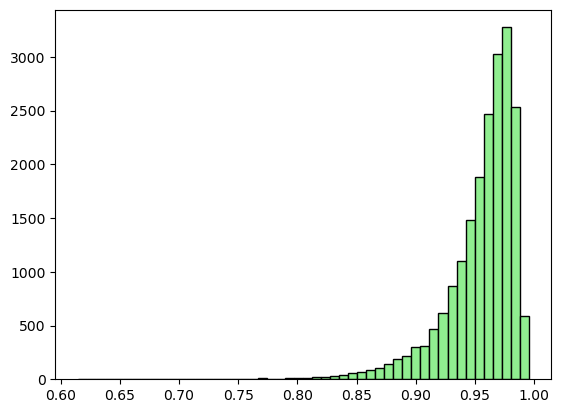

In [15]:
plt.hist(test_with_pred["predicted_score"], color='lightgreen', ec='black', bins=50)

# Evaluate using MRR@10

In [16]:
dict_qid_all_pid_prediction = {}

for qid, group in test_with_pred.groupby('query_id'):
    dict_qid_all_pid_prediction[qid] = group['passage_id'].values.tolist()


topn = 10
mrr = 0.0
qids = []
rrs = []

# iterate over all the qid (keys in the dictionary)
for qid in dict_qid_all_pid_prediction:

    rr = 0.0
    
    # iterate over all the element of topn pid [pid1, pid2, ... pid topn]
    for i, pid in enumerate(dict_qid_all_pid_prediction[qid][: topn + 1]):

        # check if the pid has relenvace > 0
        if qid in dict_of_dict_qid_pid_rel and pid in dict_of_dict_qid_pid_rel[qid] and dict_of_dict_qid_pid_rel[qid][pid] > 0:
        
            rr = 1 / (i+1)
        
            break
    qids.append(qid)
    rrs.append(rr)
    mrr += rr
mrr /= len(dict_qid_all_pid_prediction)
print("MRR@10: ", mrr)

MRR@10:  0.9151666666666675


# Evaluate using MAP@10

In [17]:
print(query_test.shape)
print(test_with_pred.shape)

result = query_test.merge(test_with_pred, how = "inner", on = ["query_id", "passage_id"])
print(result.shape)
display(result.head())

(20000, 9)
(20000, 3)
(20000, 10)


,query_id,query,used,passage_id,rank,score,username,rel,query_cleaned,predicted_score
0,203324,him functions to the paper health record,Q0,msmarco_passage_49_115778700,1,13.2671,Anserini,1,him functions to the paper health record,0.962330
1,203324,him functions to the paper health record,Q0,msmarco_passage_26_450017756,2,11.8537,Anserini,1,him functions to the paper health record,0.948867
2,203324,him functions to the paper health record,Q0,msmarco_passage_19_202396335,3,11.2738,Anserini,1,him functions to the paper health record,0.954807
3,203324,him functions to the paper health record,Q0,msmarco_passage_28_623516004,4,11.0361,Anserini,1,him functions to the paper health record,0.954931
4,203324,him functions to the paper health record,Q0,msmarco_passage_02_47181174,5,10.9476,Anserini,1,him functions to the paper health record,0.959981


In [18]:
# Function for calculating average precision for a query
def average_precision(qid, topn = 10):
    
    # ========= for each query_id, do the following:
    #print(f"Started to work on query_id {qid}")
    # get passage_id (each query_id would have upto 10 passage_id)
    qresult = result.loc[result["query_id"] == qid, ["passage_id", "rel", "predicted_score"]]


    
    # sort rows so that passages with the highest similarity ranks as top 
    qresult.sort_values(by="predicted_score", ascending = False, inplace=True)

    # # Taking Top 10 documents for the evaluation
    ranking = qresult.head(topn)['rel'].values
    #display(qresult.head(topn))
    
    # # Calculating precision
    precision=[]
    for i in range(1,11):
      if ranking[i-1]:
        precision.append(np.sum(ranking[:i])/i)
    
    # If no relevant document in list then return 0
    if precision==[]:
      return 0
    #print(len(precision))
    #print(precision)
    avg_precision = np.mean(precision)
    #print("Avg precision: {}".format(avg_precision))
    return avg_precision#, len(precision), qresult.shape[0]

In [19]:
result["avg_precision"] = result.apply(lambda x: average_precision(x['query_id'])
                                    ,axis=1)

In [20]:
result.head()

,query_id,query,used,passage_id,rank,score,username,rel,query_cleaned,predicted_score,avg_precision
0,203324,him functions to the paper health record,Q0,msmarco_passage_49_115778700,1,13.2671,Anserini,1,him functions to the paper health record,0.962330,0.77381
1,203324,him functions to the paper health record,Q0,msmarco_passage_26_450017756,2,11.8537,Anserini,1,him functions to the paper health record,0.948867,0.77381
2,203324,him functions to the paper health record,Q0,msmarco_passage_19_202396335,3,11.2738,Anserini,1,him functions to the paper health record,0.954807,0.77381
3,203324,him functions to the paper health record,Q0,msmarco_passage_28_623516004,4,11.0361,Anserini,1,him functions to the paper health record,0.954931,0.77381
4,203324,him functions to the paper health record,Q0,msmarco_passage_02_47181174,5,10.9476,Anserini,1,him functions to the paper health record,0.959981,0.77381


In [21]:
print('Mean Average Precision=>', result["avg_precision"].mean())

Mean Average Precision=> 0.836973914399093


In [ ]:
result.to_csv("./output/test_prediction_biencoder_refit_avg_precision_MiniLM-L6-v2_2024-04-22.csv"
                                       , index = False)
